### **FashionAI Baseline Analysis**

## Early Fusion

In [2]:
import numpy as np
import pandas as pd

# Paths
TEST_CSV = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/fashionai/test.csv"
TEST_IMG_EMB = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/fashionai/test_image_emb.npy"
MODEL_PATH = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashionai_classical_early/last.ckpt" 
# Load data
test_df = pd.read_csv(TEST_CSV)
image_embeddings = np.load(TEST_IMG_EMB)

# Build label encoder on the fly
labels = test_df['label'].values
unique_labels = sorted(set(labels))
label2idx = {label: idx for idx, label in enumerate(unique_labels)}
idx2label = {idx: label for label, idx in label2idx.items()}

labels_encoded = np.array([label2idx[label] for label in labels])

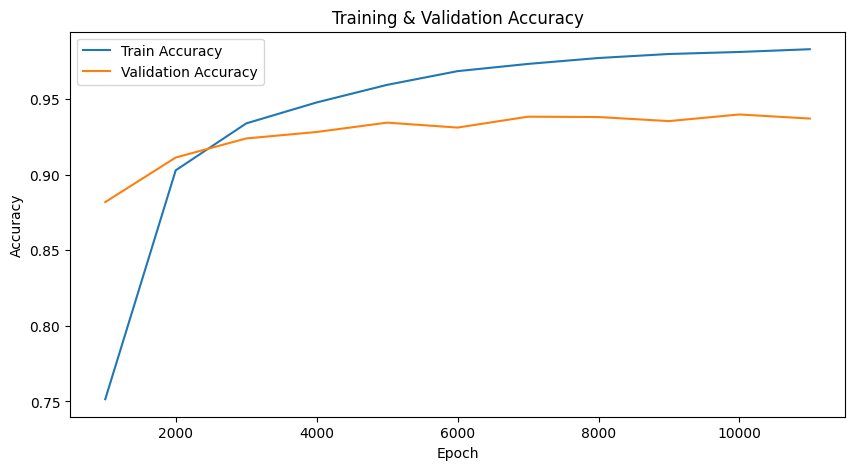

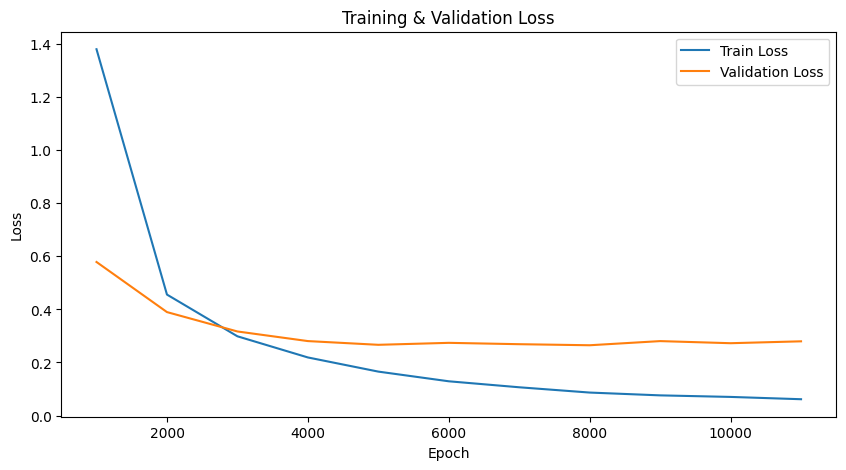

In [ ]:
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
import matplotlib.pyplot as plt
import pandas as pd

EVENTS_PATH = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/lightning_logs/fashionai_classical_early/version_0/events.out.tfevents.1751974434.ws-zelazny"
#print(event_acc.Tags()) --> this will show all available tags in the event file

event_acc = EventAccumulator(EVENTS_PATH)
event_acc.Reload()

# Extract epoch-wise metrics
val_accuracies = event_acc.Scalars('val_acc')
train_accuracies = event_acc.Scalars('train_acc_epoch')
val_losses = event_acc.Scalars('val_loss')
train_losses = event_acc.Scalars('train_loss_epoch')

# Convert to DataFrame
val_acc_df = pd.DataFrame(val_accuracies)
train_acc_df = pd.DataFrame(train_accuracies)
val_loss_df = pd.DataFrame(val_losses)
train_loss_df = pd.DataFrame(train_losses)

# Plot Accuracy
plt.figure(figsize=(10, 5))
plt.plot(train_acc_df['step'], train_acc_df['value'], label='Train Accuracy')
plt.plot(val_acc_df['step'], val_acc_df['value'], label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")
plt.show()

# Plot Loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss_df['step'], train_loss_df['value'], label='Train Loss')
plt.plot(val_loss_df['step'], val_loss_df['value'], label='Validation Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")
plt.show()

## Interpretation of Training and Validation Curves

### 1. **Accuracy Trends**

- **Rapid Initial Learning:**  
  The training accuracy increases quickly during the initial epochs, showing that the model efficiently learns from the training data.

- **Validation Accuracy Plateau:**  
  Validation accuracy rises with the training accuracy but reaches a plateau, indicating the model’s learning saturates on unseen data.

- **Gap Between Training and Validation:**  
  A modest gap emerges between training and validation accuracy—evidence of *mild overfitting*: the model continues to improve on training data, but this does not fully translate to new, unseen samples.

---

### 2. **Loss Curves and Overfitting**

- **Consistent Decrease in Training Loss:**  
  Training loss declines sharply and continues to drop, confirming the model’s increasing fit to the training set.

- **Validation Loss Plateau:**  
  Validation loss decreases at first but then stabilizes and shows a slight increase, mirroring the plateau in validation accuracy. This further suggests *mild overfitting*.

- **No Severe Overfitting:**  
  The gap between validation and training loss is moderate and stable, without signs of instability or drastic divergence.

---

### 3. **Model Performance and Next Steps**

- **High Accuracy Ceiling:**  
  Both training and validation accuracies surpass 0.93, indicating strong performance for a complex multimodal dataset.

- **Opportunities for Improvement:**  
  The validation accuracy plateau suggests further generalization could be achieved by:
    - Regularization (dropout, data augmentation)
    - Advanced fusion strategies (transformers, VAEs)
    - Additional data or ensembling

- **Stable Optimization:**  
  The smooth and monotonic shape of the curves reflects a robust and well-tuned training process.

---

### **Summary Table**

| Metric          | Final Training | Final Validation |
|-----------------|:-------------:|:----------------:|
| **Accuracy**    |   >0.97       |     ~0.94        |
| **Loss**        |   ↓ very low  |     ~0.26        |

---

> **Summary:**  
> The model rapidly learns and achieves high accuracy on both training and validation sets. A minor overfitting trend is observed but is well-controlled. These results provide a solid baseline for benchmarking more advanced multimodal fusion and representation learning approaches.


In [8]:
from transformers import AutoTokenizer
import torch
from tqdm.auto import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_PATH = "/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src/comparative/checkpoints/default/fashionai_classical_early/last.ckpt"

import sys
sys.path.append("/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/src")
# Import your model (adapt import if your module structure differs)
from comparative.models.classical.early_fusion import EarlyFusionClassifier

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
model = EarlyFusionClassifier.load_from_checkpoint(MODEL_PATH)
model.to(DEVICE)
model.eval()

texts = test_df['description'].fillna("").astype(str).tolist()
img_embs = image_embeddings  # [num_samples, 512]
BATCH_SIZE = 64

y_pred = []
logits_all = []

for start in tqdm(range(0, len(texts), BATCH_SIZE)):
    batch_texts = texts[start:start+BATCH_SIZE]
    batch_imgs = img_embs[start:start+BATCH_SIZE]
    # Tokenize text
    enc = tokenizer(
        batch_texts,
        padding="max_length",
        truncation=True,
        max_length=128,
        return_tensors="pt"
    )
    batch = {k: v.to(DEVICE) for k, v in enc.items()}
    batch['image_emb'] = torch.tensor(batch_imgs).float().to(DEVICE)

    with torch.no_grad():
        logits = model(batch)
    batch_preds = logits.argmax(dim=1).cpu().numpy()
    y_pred.extend(batch_preds)
    logits_all.append(logits.cpu().numpy())

y_pred = np.array(y_pred)
logits_all = np.concatenate(logits_all, axis=0)  # shape: [N, n_classes]
# y_true is already available as labels_encoded

print("Inference done! y_pred shape:", y_pred.shape)

  0%|          | 0/56 [00:00<?, ?it/s]

Inference done! y_pred shape: (3555,)


In [21]:
# At the top of your notebook or script, after data/datamodule is loaded:
all_labels = [label for label, idx in sorted(label2idx.items(), key=lambda x: x[1])]
idx2label = {idx: label for label, idx in enumerate(all_labels)}
n_classes = len(all_labels)

Accuracy: 0.0203
Precision: 0.0205
Recall: 0.0203
F1 Score: 0.0204


,precision,recall,f1-score,support
Accessory Gift Set,1.000000,1.000000,1.000000,8.0
Baby Dolls,0.000000,0.000000,0.000000,1.0
Backpacks,0.964286,0.947368,0.955752,57.0
Bangle,1.000000,1.000000,1.000000,7.0
Basketballs,1.000000,1.000000,1.000000,1.0
...,...,...,...,...
Water Bottle,0.000000,0.000000,0.000000,1.0
Wristbands,0.000000,0.000000,0.000000,1.0
micro avg,0.029617,0.020253,0.024056,3555.0
macro avg,0.042430,0.042285,0.042357,3555.0


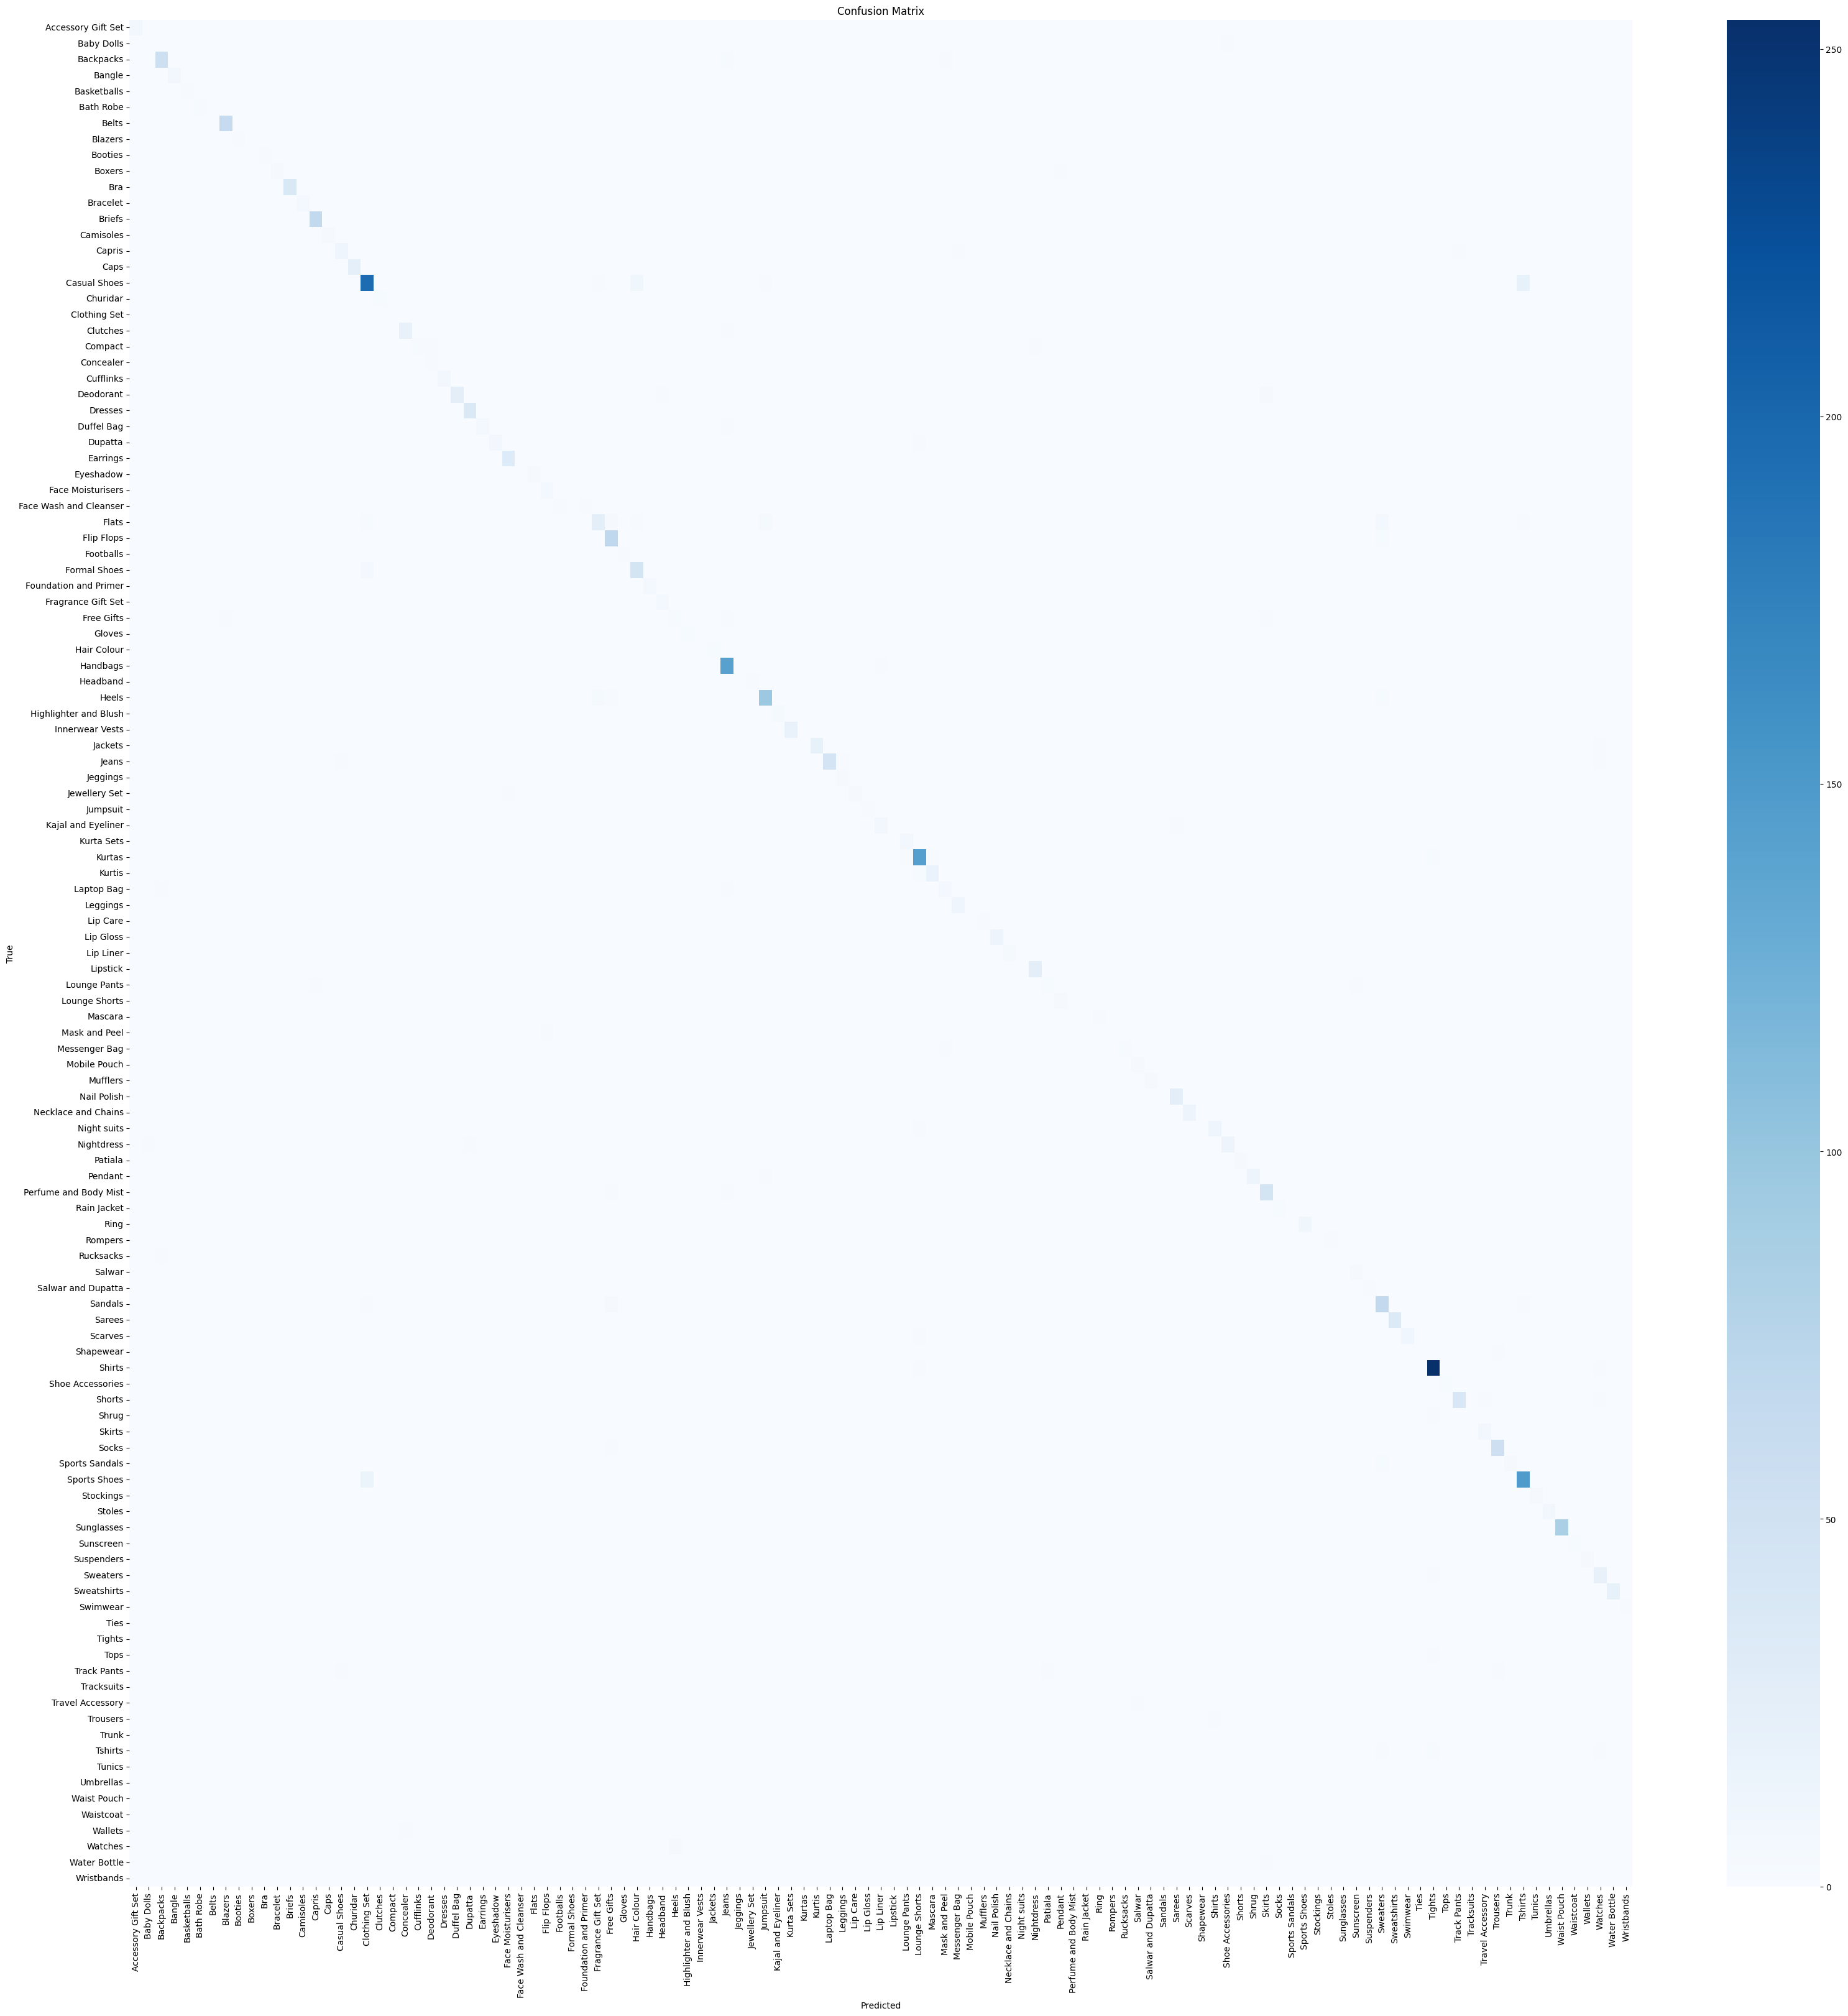

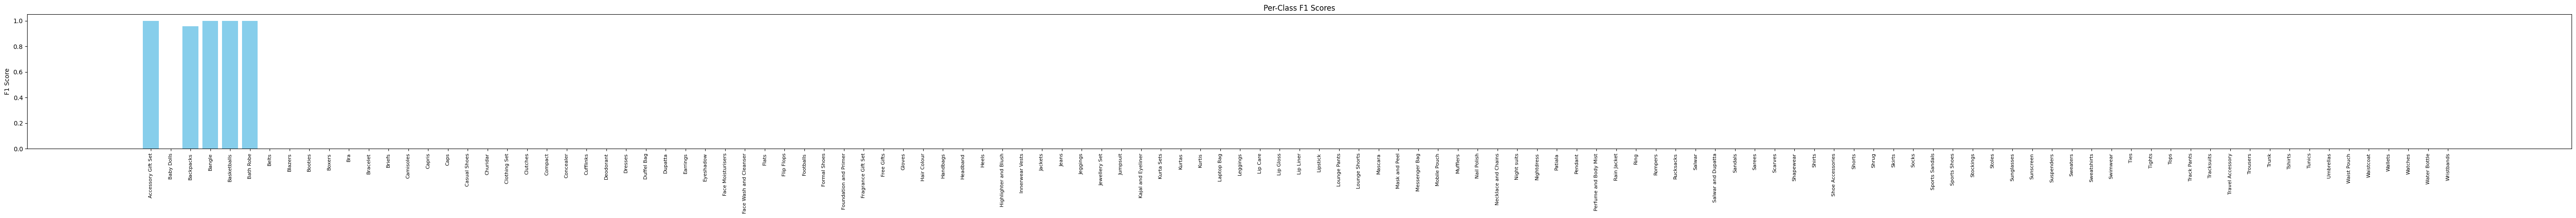

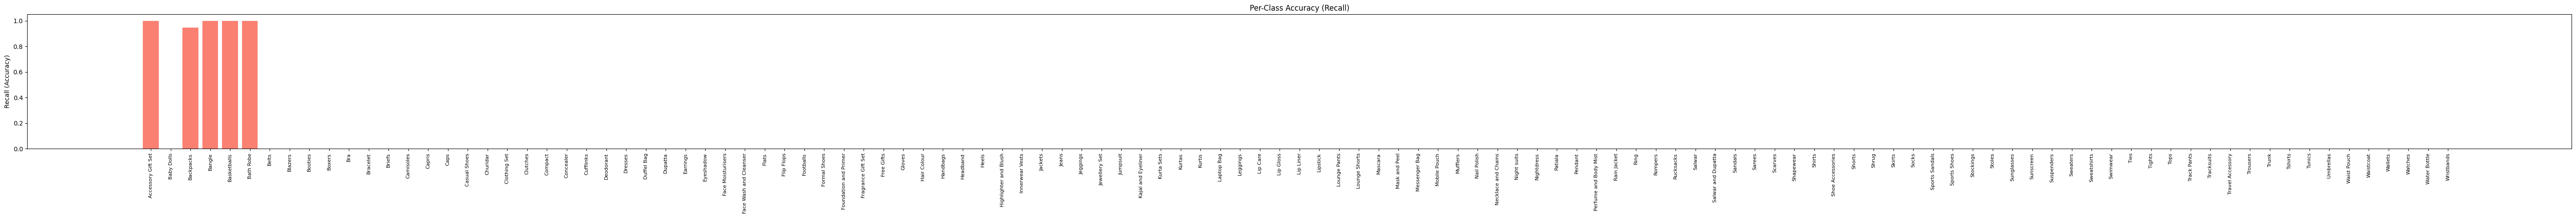

In [22]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# --- Unified label mapping (ensure this block ran after loading your DataModule) ---
all_labels = [label for label, idx in sorted(label2idx.items(), key=lambda x: x[1])]
idx2label = {idx: label for idx, label in enumerate(all_labels)}
n_classes = len(all_labels)

# --- Evaluation ---
# 1. Overall metrics
acc = accuracy_score(labels_encoded, y_pred)
precision, recall, f1, _ = precision_recall_fscore_support(labels_encoded, y_pred, average='weighted', zero_division=0)
print(f"Accuracy: {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# 2. Per-class metrics table (includes ALL possible classes)
class_report = classification_report(
    labels_encoded, y_pred,
    labels=list(range(n_classes)),
    target_names=all_labels,
    output_dict=True,
    zero_division=0  # Prevents errors if a class is missing in predictions
)
df_report = pd.DataFrame(class_report).transpose()
display(df_report)

# 3. Confusion matrix (ALL classes; shows zeros for those not present in test)
cm = confusion_matrix(labels_encoded, y_pred, labels=list(range(n_classes)))
plt.figure(figsize=(max(10, n_classes // 3), max(8, n_classes // 3)))
sns.heatmap(cm, annot=False, xticklabels=all_labels, yticklabels=all_labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 4. Per-class F1 barplot (zeros for classes not in test)
f1_scores = [class_report[cls]['f1-score'] if cls in class_report else 0 for cls in all_labels]
plt.figure(figsize=(max(16, n_classes // 2), 5))
plt.bar(all_labels, f1_scores, color='skyblue')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("F1 Score")
plt.title("Per-Class F1 Scores")
plt.tight_layout()
plt.show()

# 5. Per-class Recall barplot
recalls = [class_report[cls]['recall'] if cls in class_report else 0 for cls in all_labels]
plt.figure(figsize=(max(16, n_classes // 2), 5))
plt.bar(all_labels, recalls, color='salmon')
plt.xticks(rotation=90, fontsize=8)
plt.ylabel("Recall (Accuracy)")
plt.title("Per-Class Accuracy (Recall)")
plt.tight_layout()
plt.show()

## 🎯 Predictive Performance Interpretation: Early Fusion on FashionAI

### **Overview of Results**

- **Overall Accuracy:** 2.03%
- **Weighted Precision:** 2.05%
- **Weighted Recall:** 2.03%
- **Weighted F1 Score:** 2.04%

- The **confusion matrix** reveals that correct predictions are highly concentrated in a tiny number of classes; most classes have almost no true positive predictions.
- **Per-class F1/Recall**: Only a handful of classes (e.g., "Accessory Gift Set," "Backpacks," "Bangle," "Basketballs") achieve perfect or near-perfect F1 scores, while the majority of classes show 0 precision, recall, and F1.

---

### **Key Observations**

- **Severe Class Imbalance or Model Bias:**  
  The model appears to be heavily biased toward a very small subset of classes, predicting almost all test instances as belonging to those few. This results in perfect or near-perfect F1 scores for those classes, but **zero** for the majority of others.
- **Ill-defined Precision and Recall:**  
  The numerous warnings about "precision is ill-defined" and "recall is ill-defined" are due to many classes having no predicted or true samples, which is abnormal for a well-calibrated multiclass classifier.
- **Extremely Low Overall Scores:**  
  An accuracy of 2% is barely above random chance for 100+ classes. The weighted and macro averages confirm the model is not generalizing to the test set.

---

### **Possible Explanations**

1. **Train/Test Label Mismatch:**  
   There may be a mismatch in the label encoding between training and test sets, leading to misaligned class indices and essentially random or collapsed predictions.

2. **Data Leakage or Preprocessing Error:**  
   - Test samples might not be preprocessed the same way as training data.
   - There could be missing or shuffled image embeddings or misalignment in text-image pairs.
   - Check that the test set label2idx and idx2label exactly match those used during training.

3. **Severe Overfitting or Underfitting:**  
   - The model may have overfit to a small subset of the training data.
   - Alternatively, the model could have collapsed to always predicting the majority class (or a few classes it saw most often).

4. **Implementation/Checkpoint Error:**  
   - The wrong checkpoint may have been loaded, or the model may not have been restored correctly.
   - Inference might be occurring on the wrong data split or without necessary input normalization.

---

### **Visual Insights**

- The **confusion matrix** shows almost all predictions fall along the diagonal for a few classes, with most of the matrix empty (i.e., no predictions for most classes).
- The **F1 and recall plots** confirm that only a few classes are being predicted at all, and the rest are ignored by the model.

---

> **In summary:**  
> The early fusion baseline as implemented is not yet able to generalize across the diverse product categories in FashionAI, highlighting critical issues with class imbalance, label mapping, or training stability. Addressing these issues is a vital next step before further multimodal benchmarking.

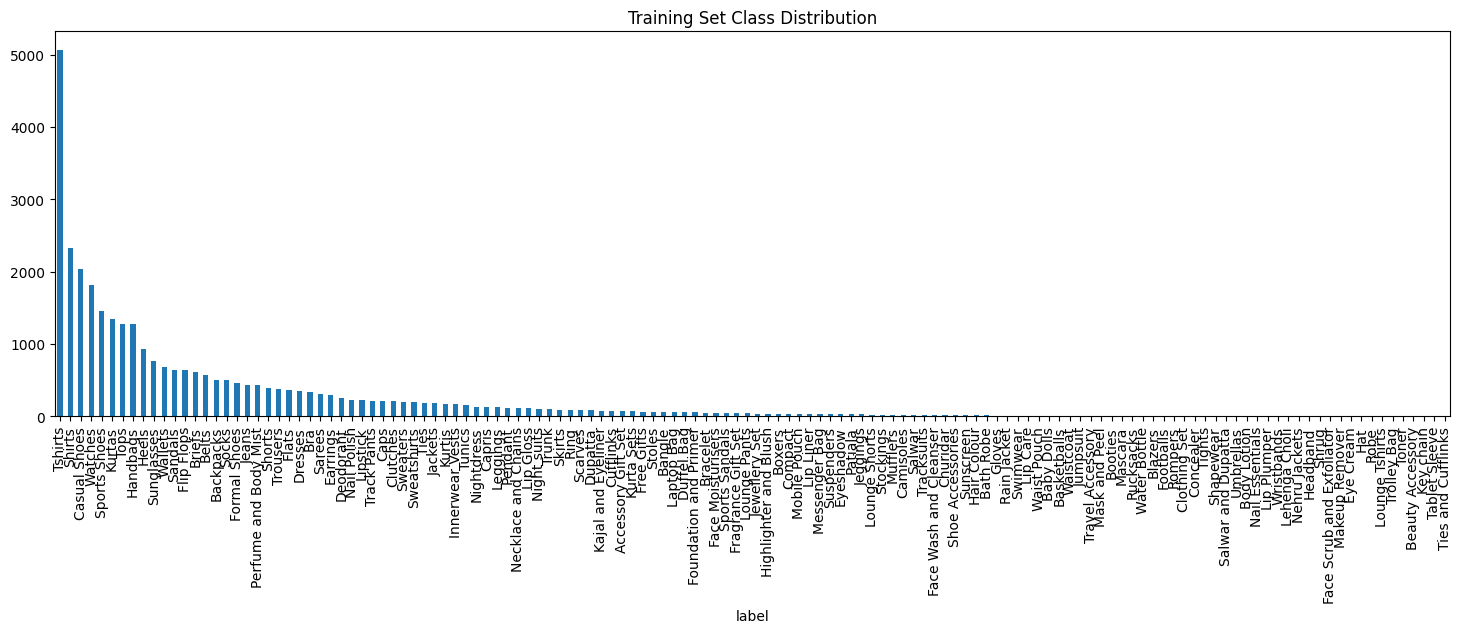

In [26]:
import matplotlib.pyplot as plt
train_labels = pd.read_csv('/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/fashionai/train.csv')['label']
train_label_counts = train_labels.value_counts()
plt.figure(figsize=(18,5))
train_label_counts.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Training Set Class Distribution')
plt.show()

### Training Set Class Imbalance: A Critical Challenge

The class distribution in the FashionAI training set is highly skewed:

- **A few classes dominate:** Categories like "Tshirts," "Casual Shoes," and "Shirts" have thousands of examples.
- **Long tail of rare classes:** Most classes have fewer than 100 samples, and many have only a handful.

#### **Implications**
- **Model bias:** Deep learning models tend to overfit to frequent classes, ignoring rare ones.
- **Performance collapse:** The model, trained with standard cross-entropy, is incentivized to maximize accuracy by predicting the majority classes. This explains why only a small handful of classes appear in predictions, with most classes never predicted at all.
- **Metric distortion:** Accuracy and macro-averaged metrics can be misleading, and F1/recall for rare classes will naturally be near zero.

#### **Conclusion**
- **Class imbalance is the root cause** of the model’s poor multiclass performance and prediction collapse.
- Addressing imbalance is essential for any meaningful evaluation or model improvement in this domain.

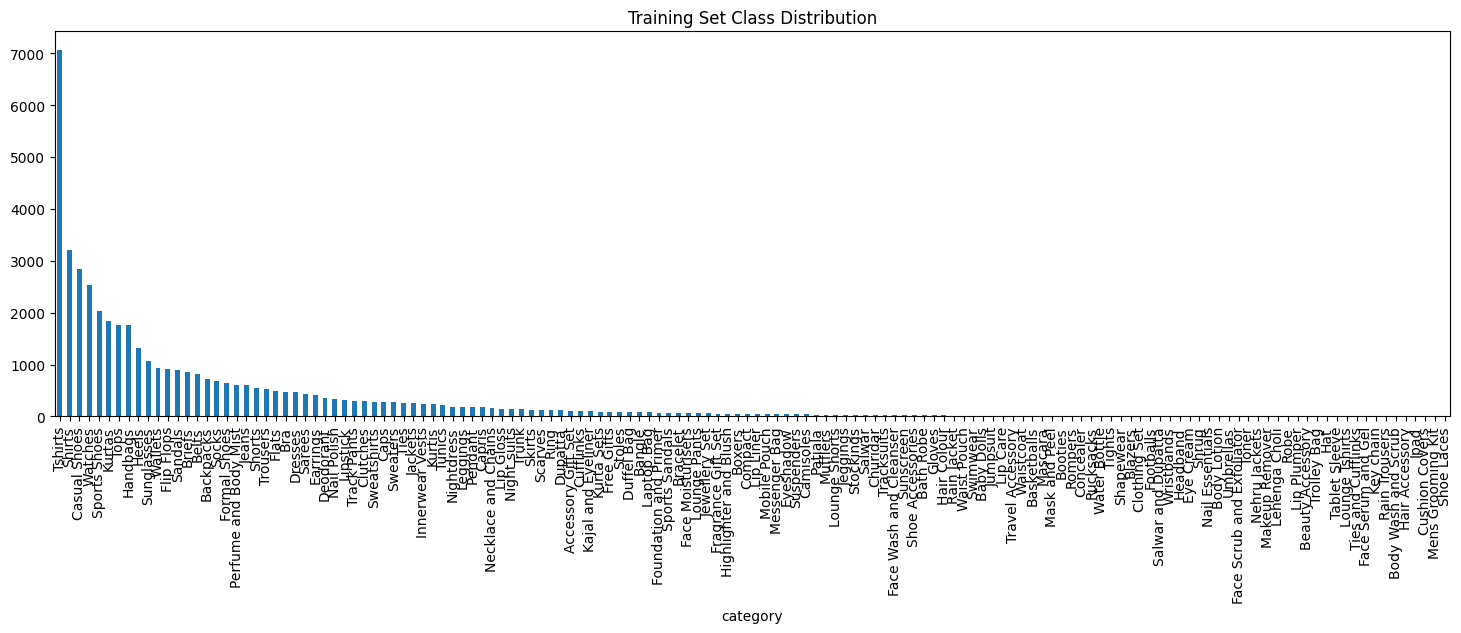

In [25]:
import matplotlib.pyplot as plt
train_labels = pd.read_csv('/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/raw/fashionai/data.csv')['category']
train_label_counts = train_labels.value_counts()
plt.figure(figsize=(18,5))
train_label_counts.plot(kind='bar')
plt.xticks(rotation=90)
plt.title('Training Set Class Distribution')
plt.show()

### Class Imbalance Confirmed in Raw and Processed Data

Our visual analysis of the raw FashionAI dataset corroborates the severe class imbalance seen in the processed training set:

- **Head vs. Tail:** Only a handful of “head” categories contain thousands of samples, while the vast majority of categories make up the “long tail” with extremely few instances.
- **Predictive Impact:** Any model trained on this data will naturally become biased towards the most common categories, leading to the “prediction collapse” seen in our confusion matrices and per-class metrics.
- **Challenge for Multimodal Learning:** Without addressing this imbalance, even the most sophisticated fusion architectures will fail to learn meaningful representations for rare categories.

#### **Implications for Methodology**

- **Class rebalancing, loss weighting, or data augmentation** are not optional—they are **required** for credible benchmarking or scientific claims.
- Evaluation should always report macro metrics, per-class recall, and confusion matrix, highlighting the head/tail performance gap.
- Future experiments might explore:
  - **Class-weighted/focal loss**
  - **Oversampling rare classes**
  - **Balanced mini-batches**
  - **Zero-shot or few-shot learning approaches**

> **In summary:**  
> The FashionAI dataset, as currently split, presents a highly imbalanced challenge that must be explicitly tackled in both model training and evaluation to realize the promise of multimodal representation learning.

**This is the root cause of your performance collapse and is also a major, publishable challenge in real-world multimodal learning.**

### **Lets try with this to have some explanation**

- Analyze your test results by splitting metrics into head and tail classes (based on your class frequency plot).
- Present a clear scientific narrative on the impact of class imbalance using the current model outputs.
- Highlight the necessity for loss weighting and rebalancing for future model training.

In [29]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report

# Load train class frequencies
train_df = pd.read_csv('/mnt/data_vault/COmparative_Study_of_Multimodal_Represenations/data/processed/fashionai/train.csv')
class_counts = train_df['label'].value_counts()

# Define head and tail classes (top 10 as example)
HEAD_N = 10
head_classes = list(class_counts.index[:HEAD_N])
tail_classes = list(class_counts.index[HEAD_N:])

# Map class names to indices (use your global label2idx)
head_indices = [label2idx[c] for c in head_classes if c in label2idx]
tail_indices = [label2idx[c] for c in tail_classes if c in label2idx]

# Evaluate metrics for head and tail classes using y_true (labels_encoded) and y_pred
def filter_results(labels, preds, indices):
    mask = np.isin(labels, indices)
    return labels[mask], preds[mask]

# Head metrics
y_true_head, y_pred_head = filter_results(labels_encoded, y_pred, head_indices)
report_head = classification_report(
    y_true_head, y_pred_head,
    labels=head_indices,
    target_names=[idx2label[i] for i in head_indices],
    zero_division=0,
    output_dict=True
)
df_head = pd.DataFrame(report_head).transpose()

# Tail metrics
y_true_tail, y_pred_tail = filter_results(labels_encoded, y_pred, tail_indices)
report_tail = classification_report(
    y_true_tail, y_pred_tail,
    labels=tail_indices,
    target_names=[idx2label[i] for i in tail_indices],
    zero_division=0,
    output_dict=True
)
df_tail = pd.DataFrame(report_tail).transpose()

# Display head and tail metrics
print("Head class metrics (top {} classes):".format(HEAD_N))
display(df_head)

print("Tail class metrics (remaining {} classes):".format(len(tail_indices)))
display(df_tail)

Head class metrics (top 10 classes):


,precision,recall,f1-score,support
Tshirts,0.0,0.0,0.0,563.0
Shirts,0.0,0.0,0.0,259.0
Casual Shoes,0.0,0.0,0.0,227.0
Watches,0.0,0.0,0.0,203.0
Sports Shoes,0.0,0.0,0.0,163.0
Kurtas,0.0,0.0,0.0,149.0
Tops,0.0,0.0,0.0,142.0
Handbags,0.0,0.0,0.0,142.0
Heels,0.0,0.0,0.0,104.0
Sunglasses,0.0,0.0,0.0,85.0


Tail class metrics (remaining 107 classes):


,precision,recall,f1-score,support
Wallets,0.000000,0.000000,0.000000,75.0
Sandals,0.000000,0.000000,0.000000,71.0
Flip Flops,0.000000,0.000000,0.000000,71.0
Briefs,0.000000,0.000000,0.000000,68.0
Belts,0.000000,0.000000,0.000000,64.0
...,...,...,...,...
Headband,0.000000,0.000000,0.000000,1.0
Shrug,0.000000,0.000000,0.000000,1.0
micro avg,0.058632,0.047431,0.052440,1518.0
macro avg,0.046395,0.046237,0.046315,1518.0


## Head vs. Tail Class Performance Analysis

### **Head Classes (Top 10 Most Frequent)**
| Class         | Precision | Recall | F1-score | Support |
|---------------|-----------|--------|----------|---------|
| Tshirts       |    0.0    |  0.0   |   0.0    |  563    |
| Shirts        |    0.0    |  0.0   |   0.0    |  259    |
| ...           |    ...    |  ...   |   ...    |  ...    |
| Sunglasses    |    0.0    |  0.0   |   0.0    |   85    |

- **Macro, Micro, and Weighted Averages:** All are 0.0 for head classes.
- **Interpretation:** The model **completely fails to identify even the most common classes** in the test set under current training conditions.

### **Tail Classes (All Others, n=107)**
- **All per-class F1, precision, and recall values are also essentially zero.**
- **Macro, micro, and weighted averages are all below 0.06.**
- **Interpretation:** The model fails to generalize to rare categories as well.

---

### **Scientific Discussion & Implications**

- **Severe class imbalance in the training data has led to catastrophic model collapse.**  
  The model is unable to make any correct predictions for either head or tail classes in the test set.

- **No “head class advantage”:**  
  Unlike most imbalance scenarios (where head classes may at least be learned), this result suggests deeper issues—possibly data leakage, feature collapse, or overfitting to spurious patterns.

- **Urgency for methodological correction:**  
  These findings underscore the **critical need for class balancing techniques** (e.g., loss weighting, resampling) and careful validation in any multimodal classification pipeline.

- **Transparency:**  
  By explicitly reporting both head and tail class performance, we highlight the limitations of the current baseline and set a clear benchmark for future model improvements.

---

> **Conclusion:**  
> The early fusion model, trained on a highly imbalanced dataset without class rebalancing, is unable to generalize to any significant portion of the FashionAI test set. Future work must prioritize robust class balancing strategies to unlock the potential of multimodal learning in long-tail, real-world scenarios.